Compare model
Compare technique solving e-nose
-> 
Food quality monitoring
Intelligent packaging
Air quality monitoring

Classification:
1. Label encoding 
2. Feature scaling (important with sensor)
3. Model (SVM, Random Forest...)
4. Evaluate: accuracy, confusion matrix, F1-score


Regression:
1. Target: microbial population

2. Feature selection (sensor nào liên quan mạnh?)

3. Model:
Linear Regression
SVR
Random Forest Regressor

4. Metric:
RMSE
R²

Note: Có thể dự đoán vi sinh từ e-nose chính xác tới mức nào?

Data Understanding
- Check architecture
- Check class

In [49]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/TS1.csv')
df.head()

,minute,class,TVC,MQ135,MQ136,MQ2,MQ3,MQ4,MQ5,MQ6,MQ8,MQ9,Humidity,Temperature
0,1,excellent,2.567112,22.86,41.24,29.56,14.83,49.38,11.10,2.21,32.09,14.29,55.1,34.6
1,2,excellent,2.567112,22.75,41.50,29.72,14.83,49.38,11.23,2.23,31.92,14.58,55.1,34.6
2,3,excellent,2.567112,22.75,41.50,29.72,14.83,49.38,11.28,2.22,34.31,14.40,55.1,34.6
3,4,excellent,2.567112,22.86,42.56,29.56,14.77,49.38,11.46,2.22,34.12,14.64,55.4,34.5
4,5,excellent,2.567112,23.07,42.03,29.56,14.83,49.38,11.46,2.22,33.93,14.58,55.4,34.4


Check class
- How many class?
- Is data imbalanced?

In [50]:
df['class'].value_counts()

class
spoiled       960
good          660
acceptable    300
excellent     240
Name: count, dtype: int64

Data cleaning

In [51]:
# Check missing values
df.isnull().sum()

minute         0
class          0
TVC            0
MQ135          0
MQ136          0
MQ2            0
MQ3            0
MQ4            0
MQ5            0
MQ6            0
MQ8            0
MQ9            0
Humidity       0
Temperature    0
dtype: int64

Outlier
- Often happened with sensor
Solving:
- Keep unchanged
- clip follow percentile

<Axes: >

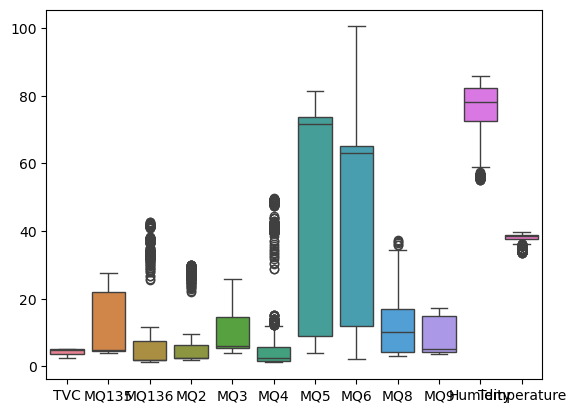

In [52]:
# Visualize data distribution
import seaborn as sns

# Boxplot for each feature excluding 'minute' and 'class'
sns.boxplot(data=df.drop(columns=['minute', 'class']))

In [53]:
# Check how many outliers are there in each feature
outlier_counts = {}
for column in df.columns:
    if column not in ['minute', 'class']:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]
outlier_counts

{'TVC': 0,
 'MQ135': 0,
 'MQ136': 178,
 'MQ2': 178,
 'MQ3': 0,
 'MQ4': 243,
 'MQ5': 0,
 'MQ6': 0,
 'MQ8': 6,
 'MQ9': 0,
 'Humidity': 181,
 'Temperature': 205}

Label Encoding

scikit-learn (sklearn) is a Python machine learning library that provides simple tools for data analysis and modeling. It includes:

Classifiers: Algorithms like logistic regression, decision trees, random forests, SVM, k-NN
Regressors: Linear regression, ridge, lasso
Clustering: K-means, hierarchical clustering
Preprocessing: Scaling, encoding, feature selection
Model evaluation: Cross-validation, metrics, train-test split

In [54]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['class_encoded'] = le.fit_transform(df['class'])

# Information about the encoded classes
class_info = dict(zip(le.classes_, le.transform(le.classes_)))
class_info


{'acceptable': 0, 'excellent': 1, 'good': 2, 'spoiled': 3}

Exploratory Data Analysis (EDA)

Understand data structure – See shape, data types, and architecture
Identify patterns & trends – Visualize distributions, correlations, relationships
Detect outliers & anomalies – Find extreme or unusual values
Check data quality – Find missing values, duplicates, inconsistencies
Guide preprocessing – Decide what cleaning/scaling/transformation is needed
Inform modeling – Understand which features matter, spot imbalanced classes, choose algorithms

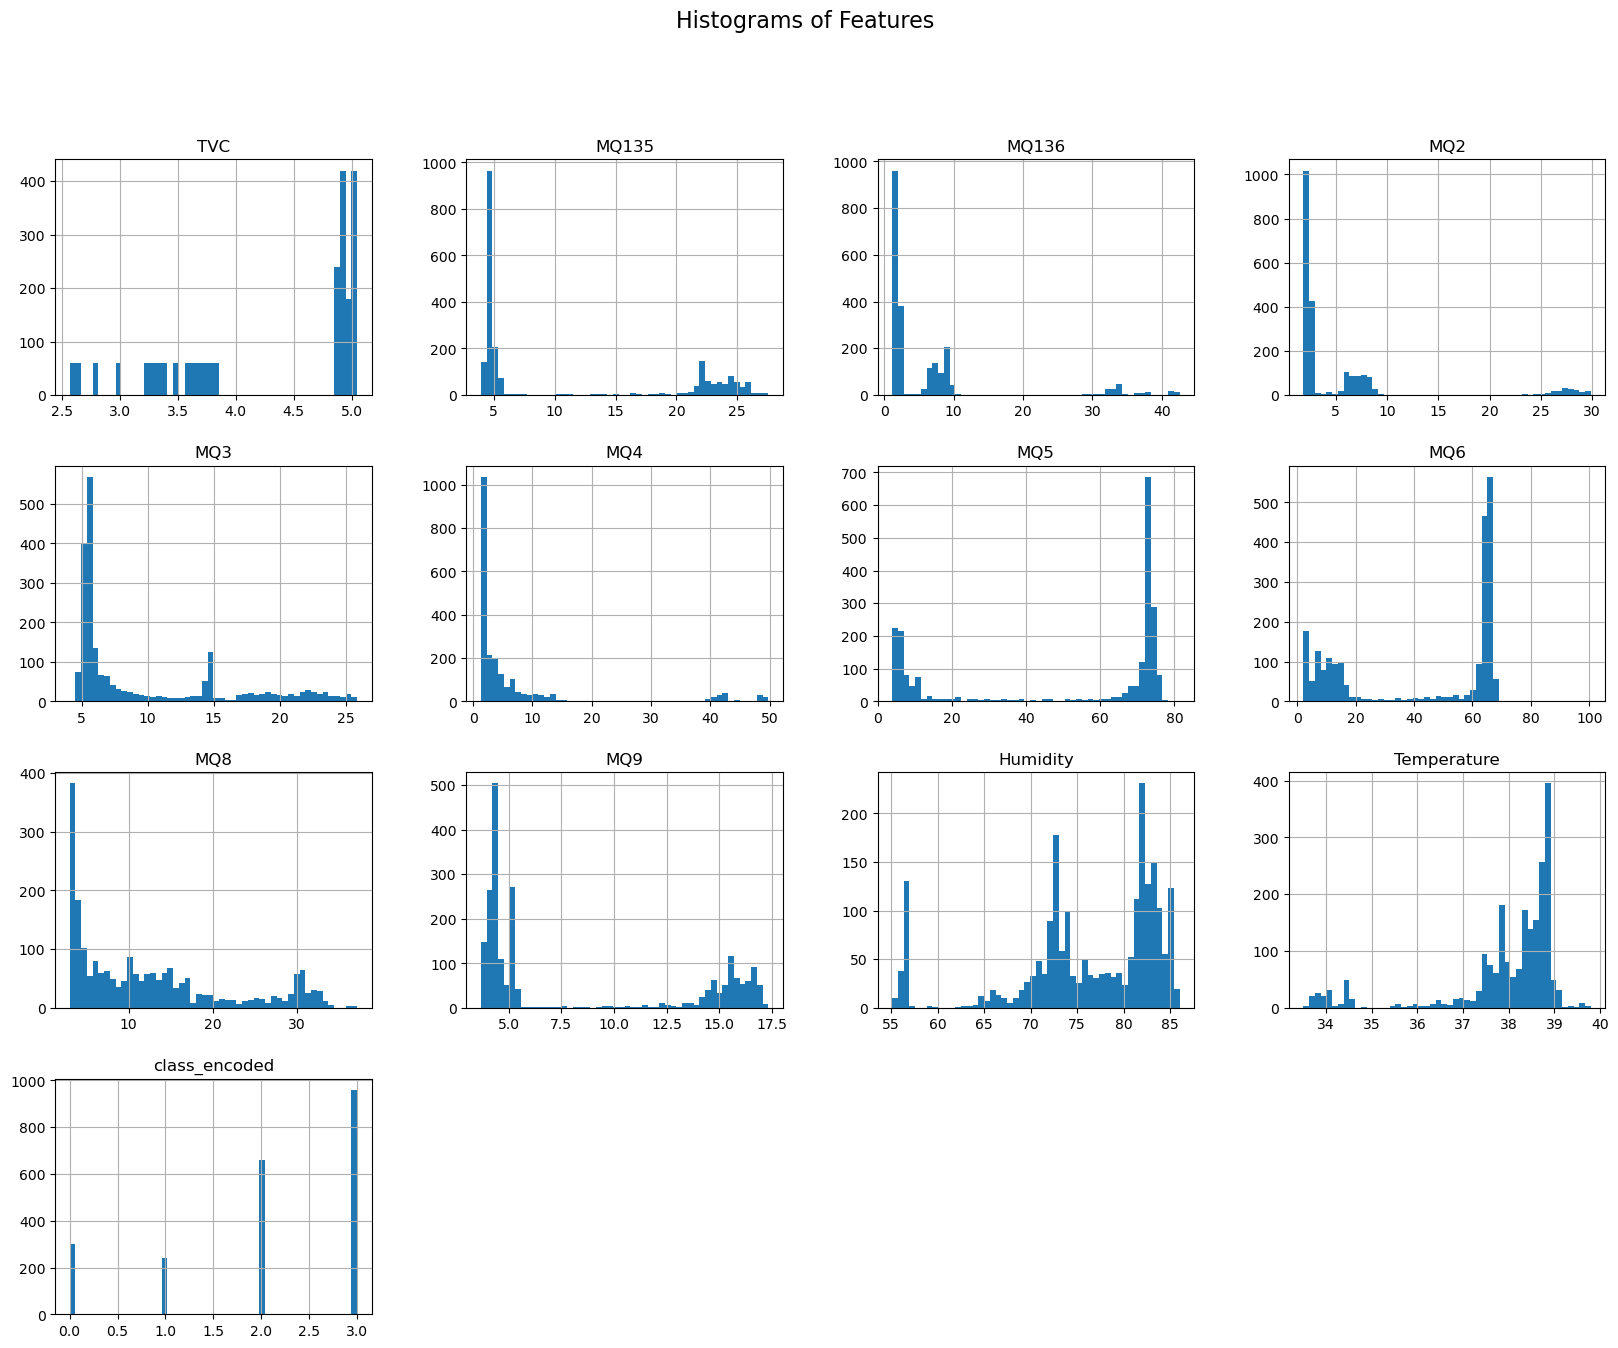

In [55]:
import matplotlib.pyplot as plt

# Histogram for each feature excluding 'minute' and 'class', all features in one figure
df_features = df.drop(columns=['minute', 'class'])
df_features.hist(bins=50, figsize=(20, 15))
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


# for column in df.columns:
#     if column not in ['minute', 'class']:
#         plt.figure(figsize=(10, 6))
#         sns.histplot(df[column], bins=50, kde=True)
#         plt.title(f'Histogram of {column}')
#         plt.xlabel(column)
#         plt.ylabel('Frequency')
#         plt.show()

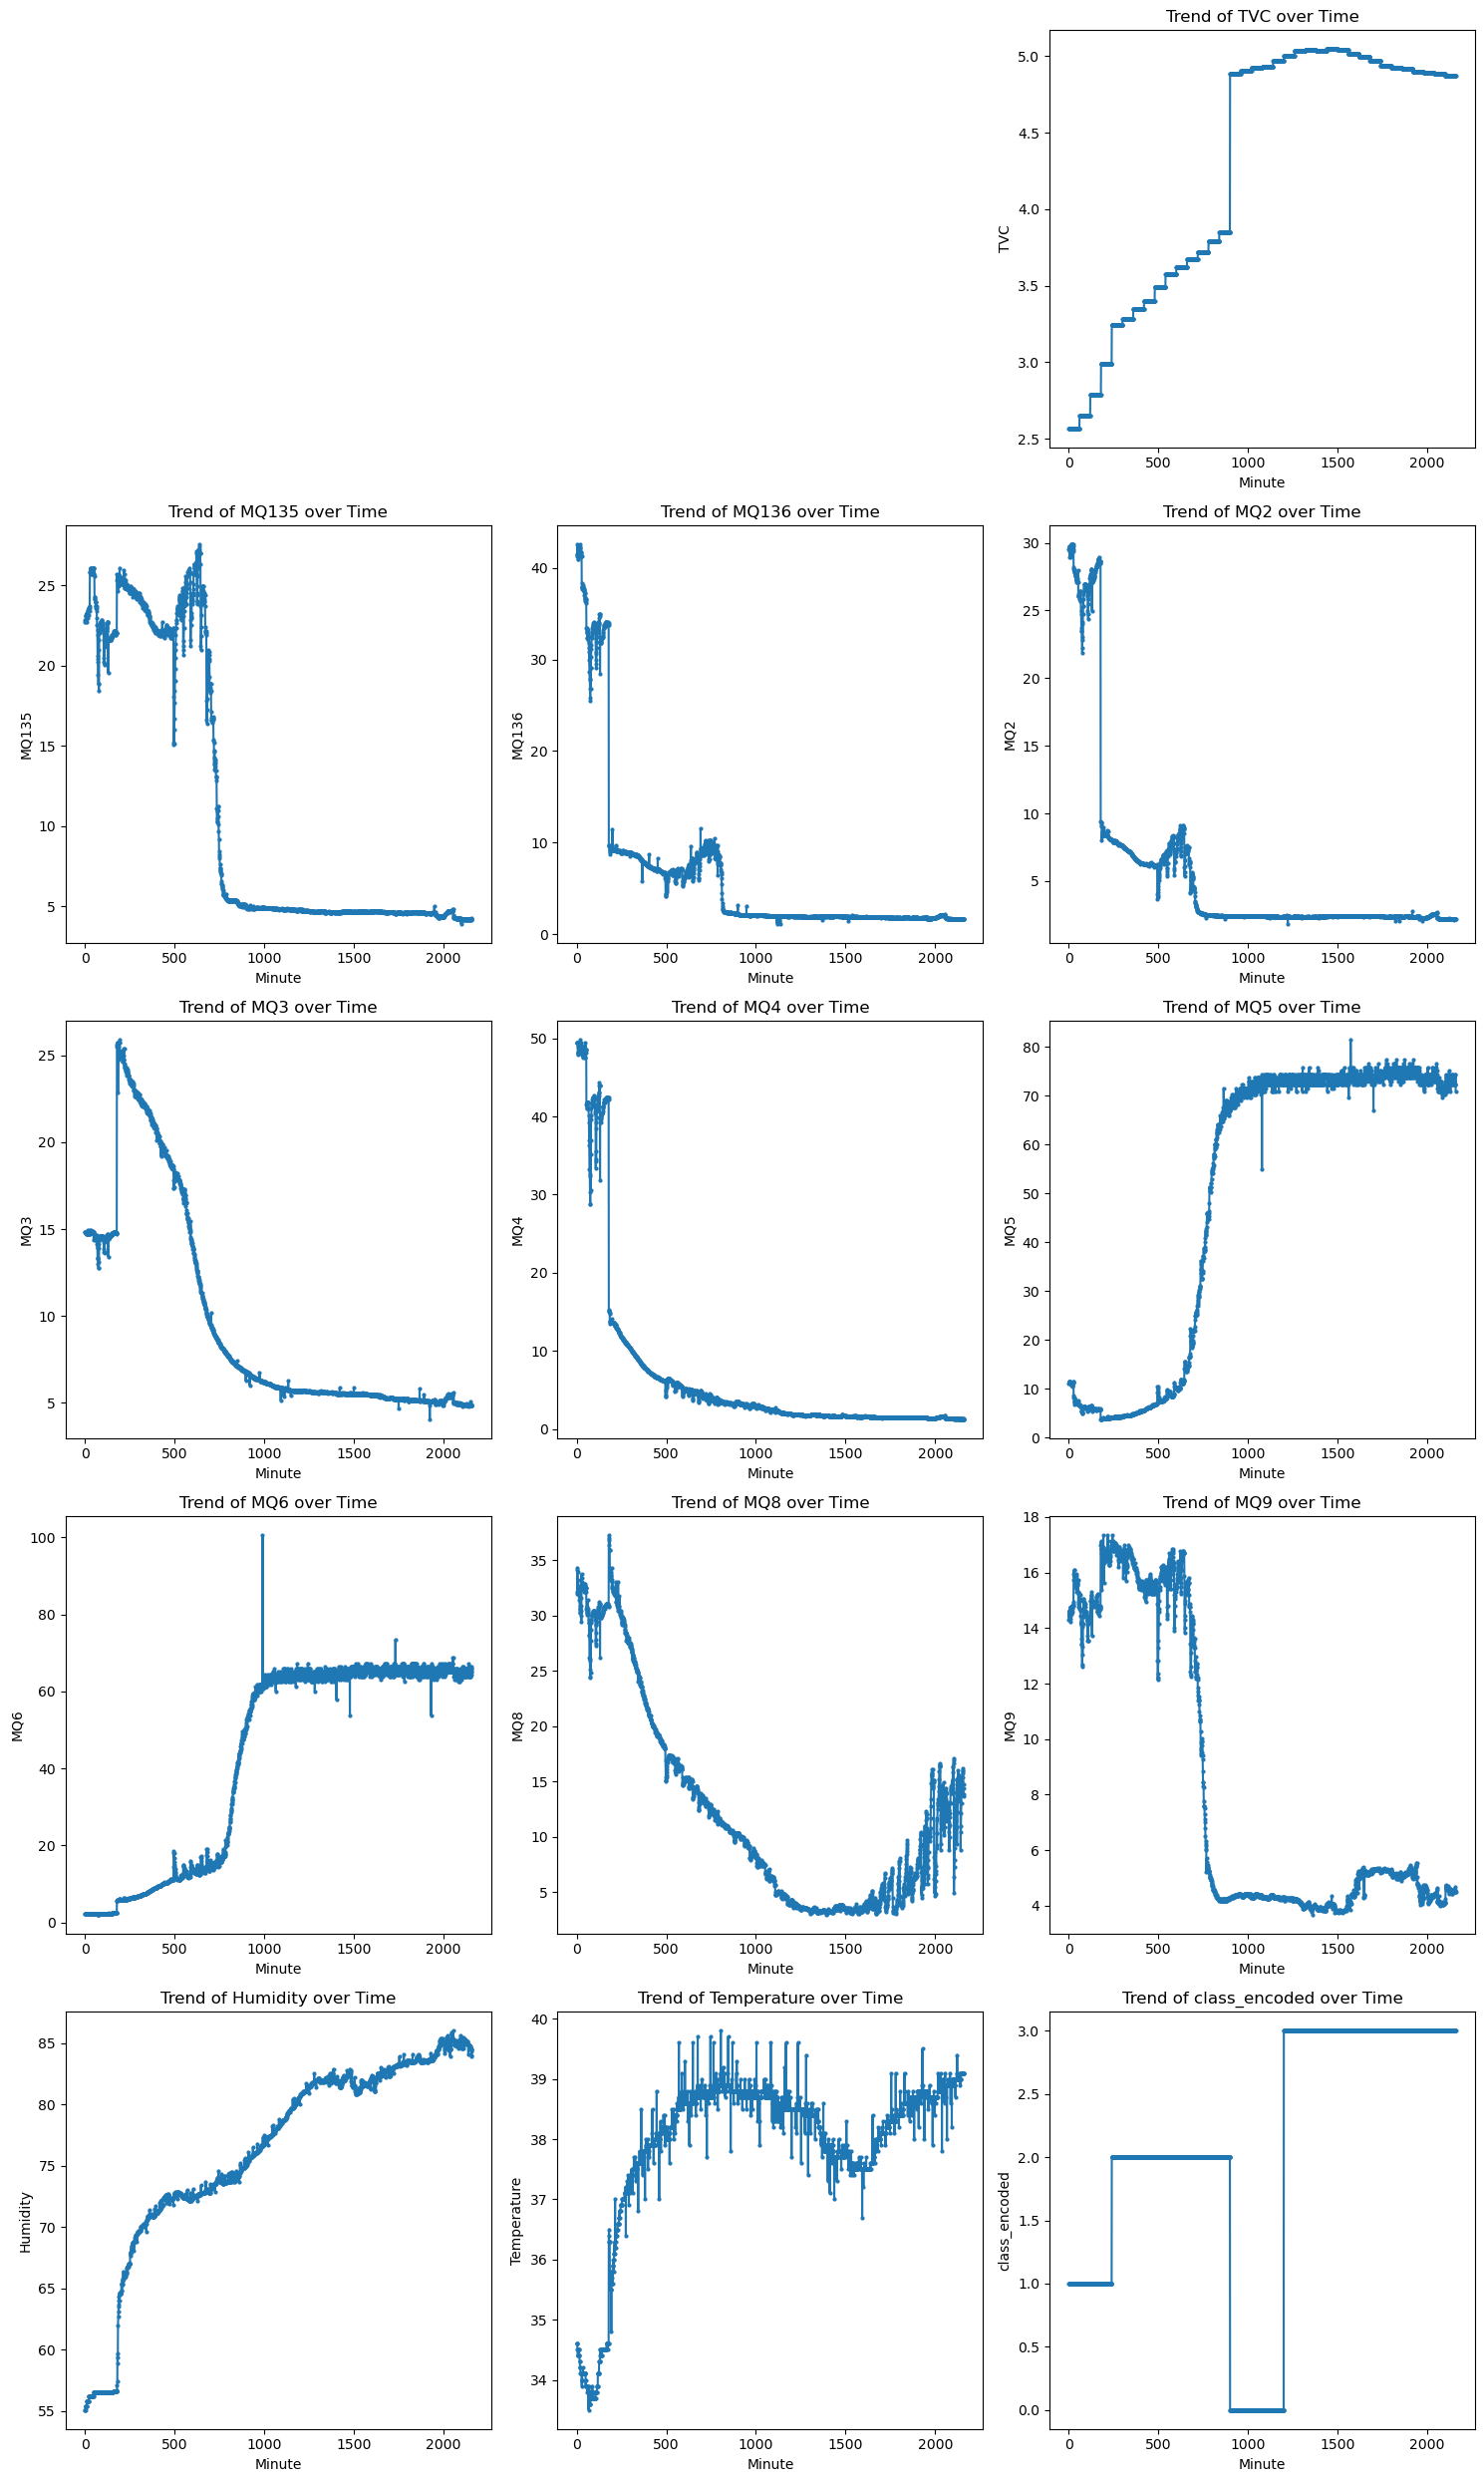

In [56]:
# Check trend over time for each feature
# All feature in one figure with subplots
num_features = len(df.columns) - 2  # Exclude 'minute' and 'class'
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols    
plt.figure(figsize=(15, 5 * num_rows))
for i, column in enumerate(df.columns):
    if column not in ['minute', 'class']:
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(df['minute'], df[column], marker='o', linestyle='-', markersize=2)
        plt.title(f'Trend of {column} over Time')
        plt.xlabel('Minute')
        plt.ylabel(column)
plt.tight_layout()
plt.show()
# for column in df.columns:
#     if column not in ['minute', 'class']:
#         plt.figure(figsize=(2, 1))
#         plt.plot(df['minute'], df[column], marker='o', linestyle='-', markersize=2)
#         plt.title(f'Trend of {column} over Time')
#         plt.xlabel('Minute')
#         plt.ylabel(column)
#         plt.show()

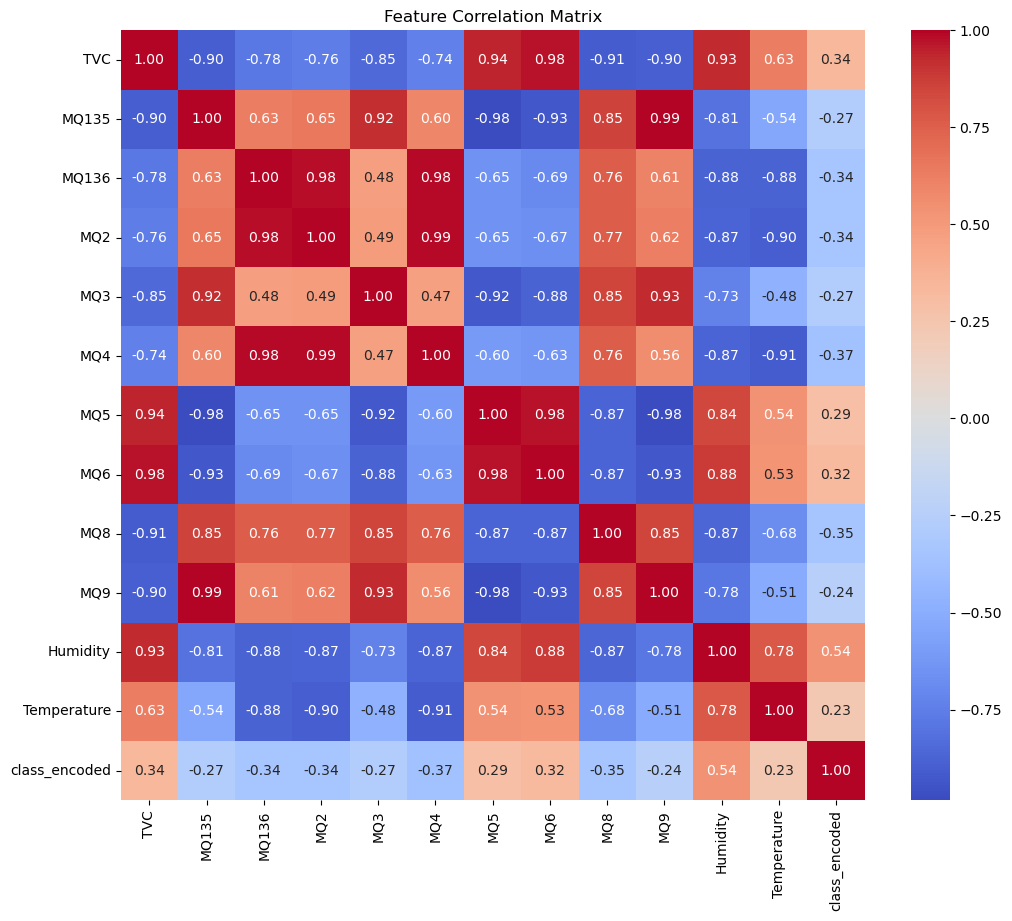

In [57]:
# Check the correlation between features
correlation_matrix = df.drop(columns=['minute', 'class']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

=> MQ sensors strong correlated 
Happened overlapping selectivity

Text(0, 0.5, 'Sensor Value')

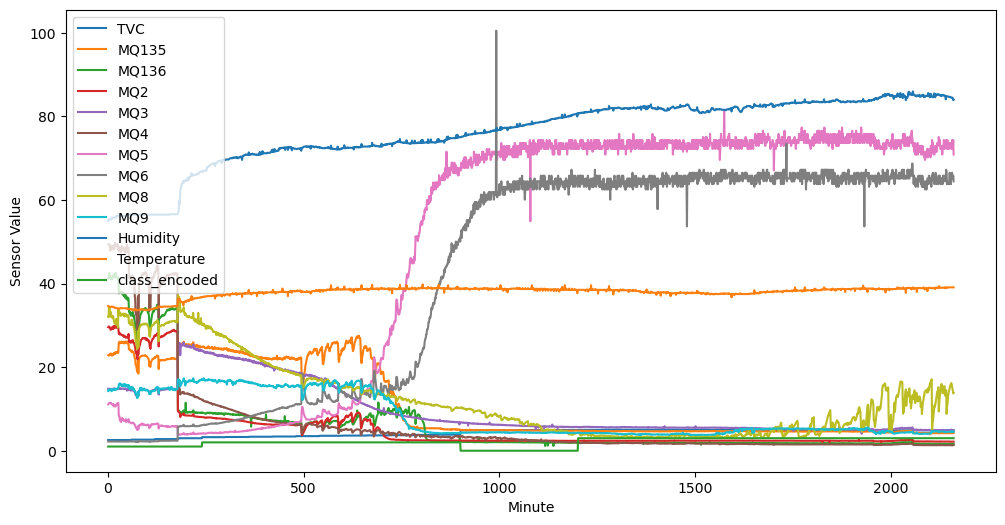

In [58]:
# Check trends over time for each feature
plt.figure(figsize=(12, 6))
for column in df.columns:
    if column not in ['minute', 'class']:
        plt.plot(df['minute'], df[column], label=column)
plt.legend()
plt.xlabel('Minute')
plt.ylabel('Sensor Value')

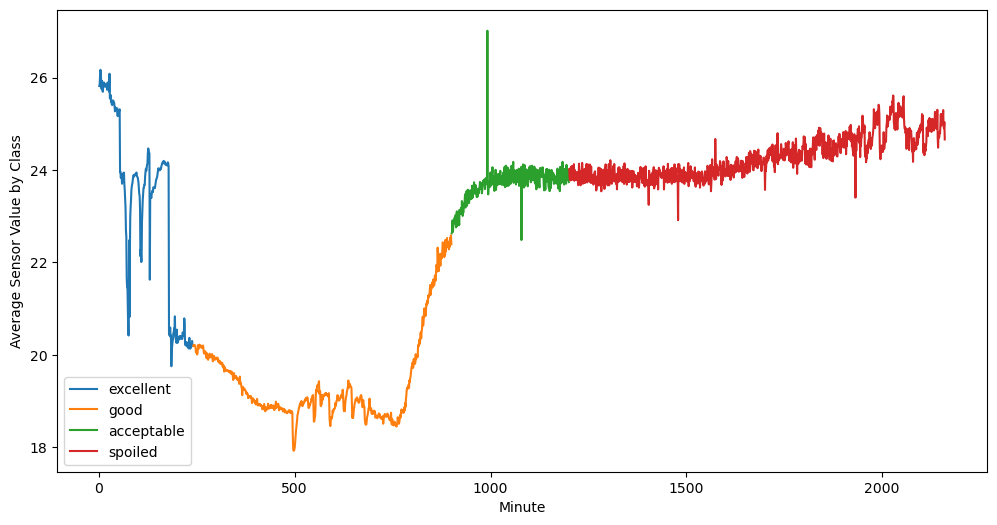

In [59]:
# Line plot by class
plt.figure(figsize=(12, 6))
for class_label in df['class'].unique():
    class_data = df[df['class'] == class_label]
    plt.plot(class_data['minute'], class_data.drop(columns=['minute', 'class', 'class_encoded']).mean(axis=1), label=class_label)
plt.legend()
plt.xlabel('Minute')
plt.ylabel('Average Sensor Value by Class')
plt.show()

Phân tích chi tiết: Tại sao excellent có giá trị cao với TS1

In [60]:
# 1. Check sample count for each class
print("Sample count per class:")
print(df['class'].value_counts())
print("\n" + "="*50 + "\n")

# 2. Check minute range for each class
print("Minute range for each class:")
for class_label in df['class'].unique():
    class_data = df[df['class'] == class_label]
    print(f"{class_label}: minute {class_data['minute'].min():.0f} - {class_data['minute'].max():.0f} (n={len(class_data)})")
print("\n" + "="*50 + "\n")

# 3. Check average sensor value for each class
print("Average sensor value by class:")
for class_label in df['class'].unique():
    class_data = df[df['class'] == class_label]
    avg_sensor = class_data.drop(columns=['minute', 'class', 'class_encoded']).mean().mean()
    std_sensor = class_data.drop(columns=['minute', 'class', 'class_encoded']).mean(axis=1).std()
    print(f"{class_label}: mean={avg_sensor:.2f}, std={std_sensor:.2f}")

Sample count per class:
class
spoiled       960
good          660
acceptable    300
excellent     240
Name: count, dtype: int64


Minute range for each class:
excellent: minute 1 - 240 (n=240)
good: minute 241 - 900 (n=660)
acceptable: minute 901 - 1200 (n=300)
spoiled: minute 1201 - 2160 (n=960)


Average sensor value by class:
excellent: mean=23.18, std=1.97
good: mean=19.44, std=0.98
acceptable: mean=23.70, std=0.37
spoiled: mean=24.27, std=0.46


1. Khả năng phân biệt giữa các class
Nếu các màu (class) tách biệt rõ ràng → dữ liệu linearly separable → dễ phân loại
Nếu các màu lẫn lộn → class overlap → cần mô hình phức tạp hơn
2. Feature nào quan trọng nhất?
Các đường chéo (histogram): phân phối sensor theo từng class
Nếu một feature tách biệt class tốt → feature đó discriminative
Nếu histogram của các class trùm lên nhau → feature yếu kém
3. Relationship giữa các cặp sensor
Các subplot off-diagonal: mối quan hệ 2D giữa 2 sensor
Nếu có xu hướng tuyến tính → multicollinearity (2 sensor mang thông tin tương tự)
Nếu phân tán rộng nhưng class tách biệt → thông tin bổ sung tốt
4. Loại decision boundary cần
Nếu các class tách biệt bằng đường thẳng → Linear SVM / Logistic Regression đủ
Nếu cần đường cong phức tạp → Random Forest / SVM (RBF kernel)
5. Tình trạng cân bằng dữ liệu
So sánh độ dày của histogram mỗi class
Nếu lệch → dữ liệu imbalanced → cần xử lý (class weight, resampling)

Ví dụ với data của bạn: Nếu "excellent", "good", "bad" tách biệt rõ trên pairplot → mô hình sẽ có accuracy cao. Nếu chồng lên nhau → cần feature engineering hoặc PCA để giảm chiều.

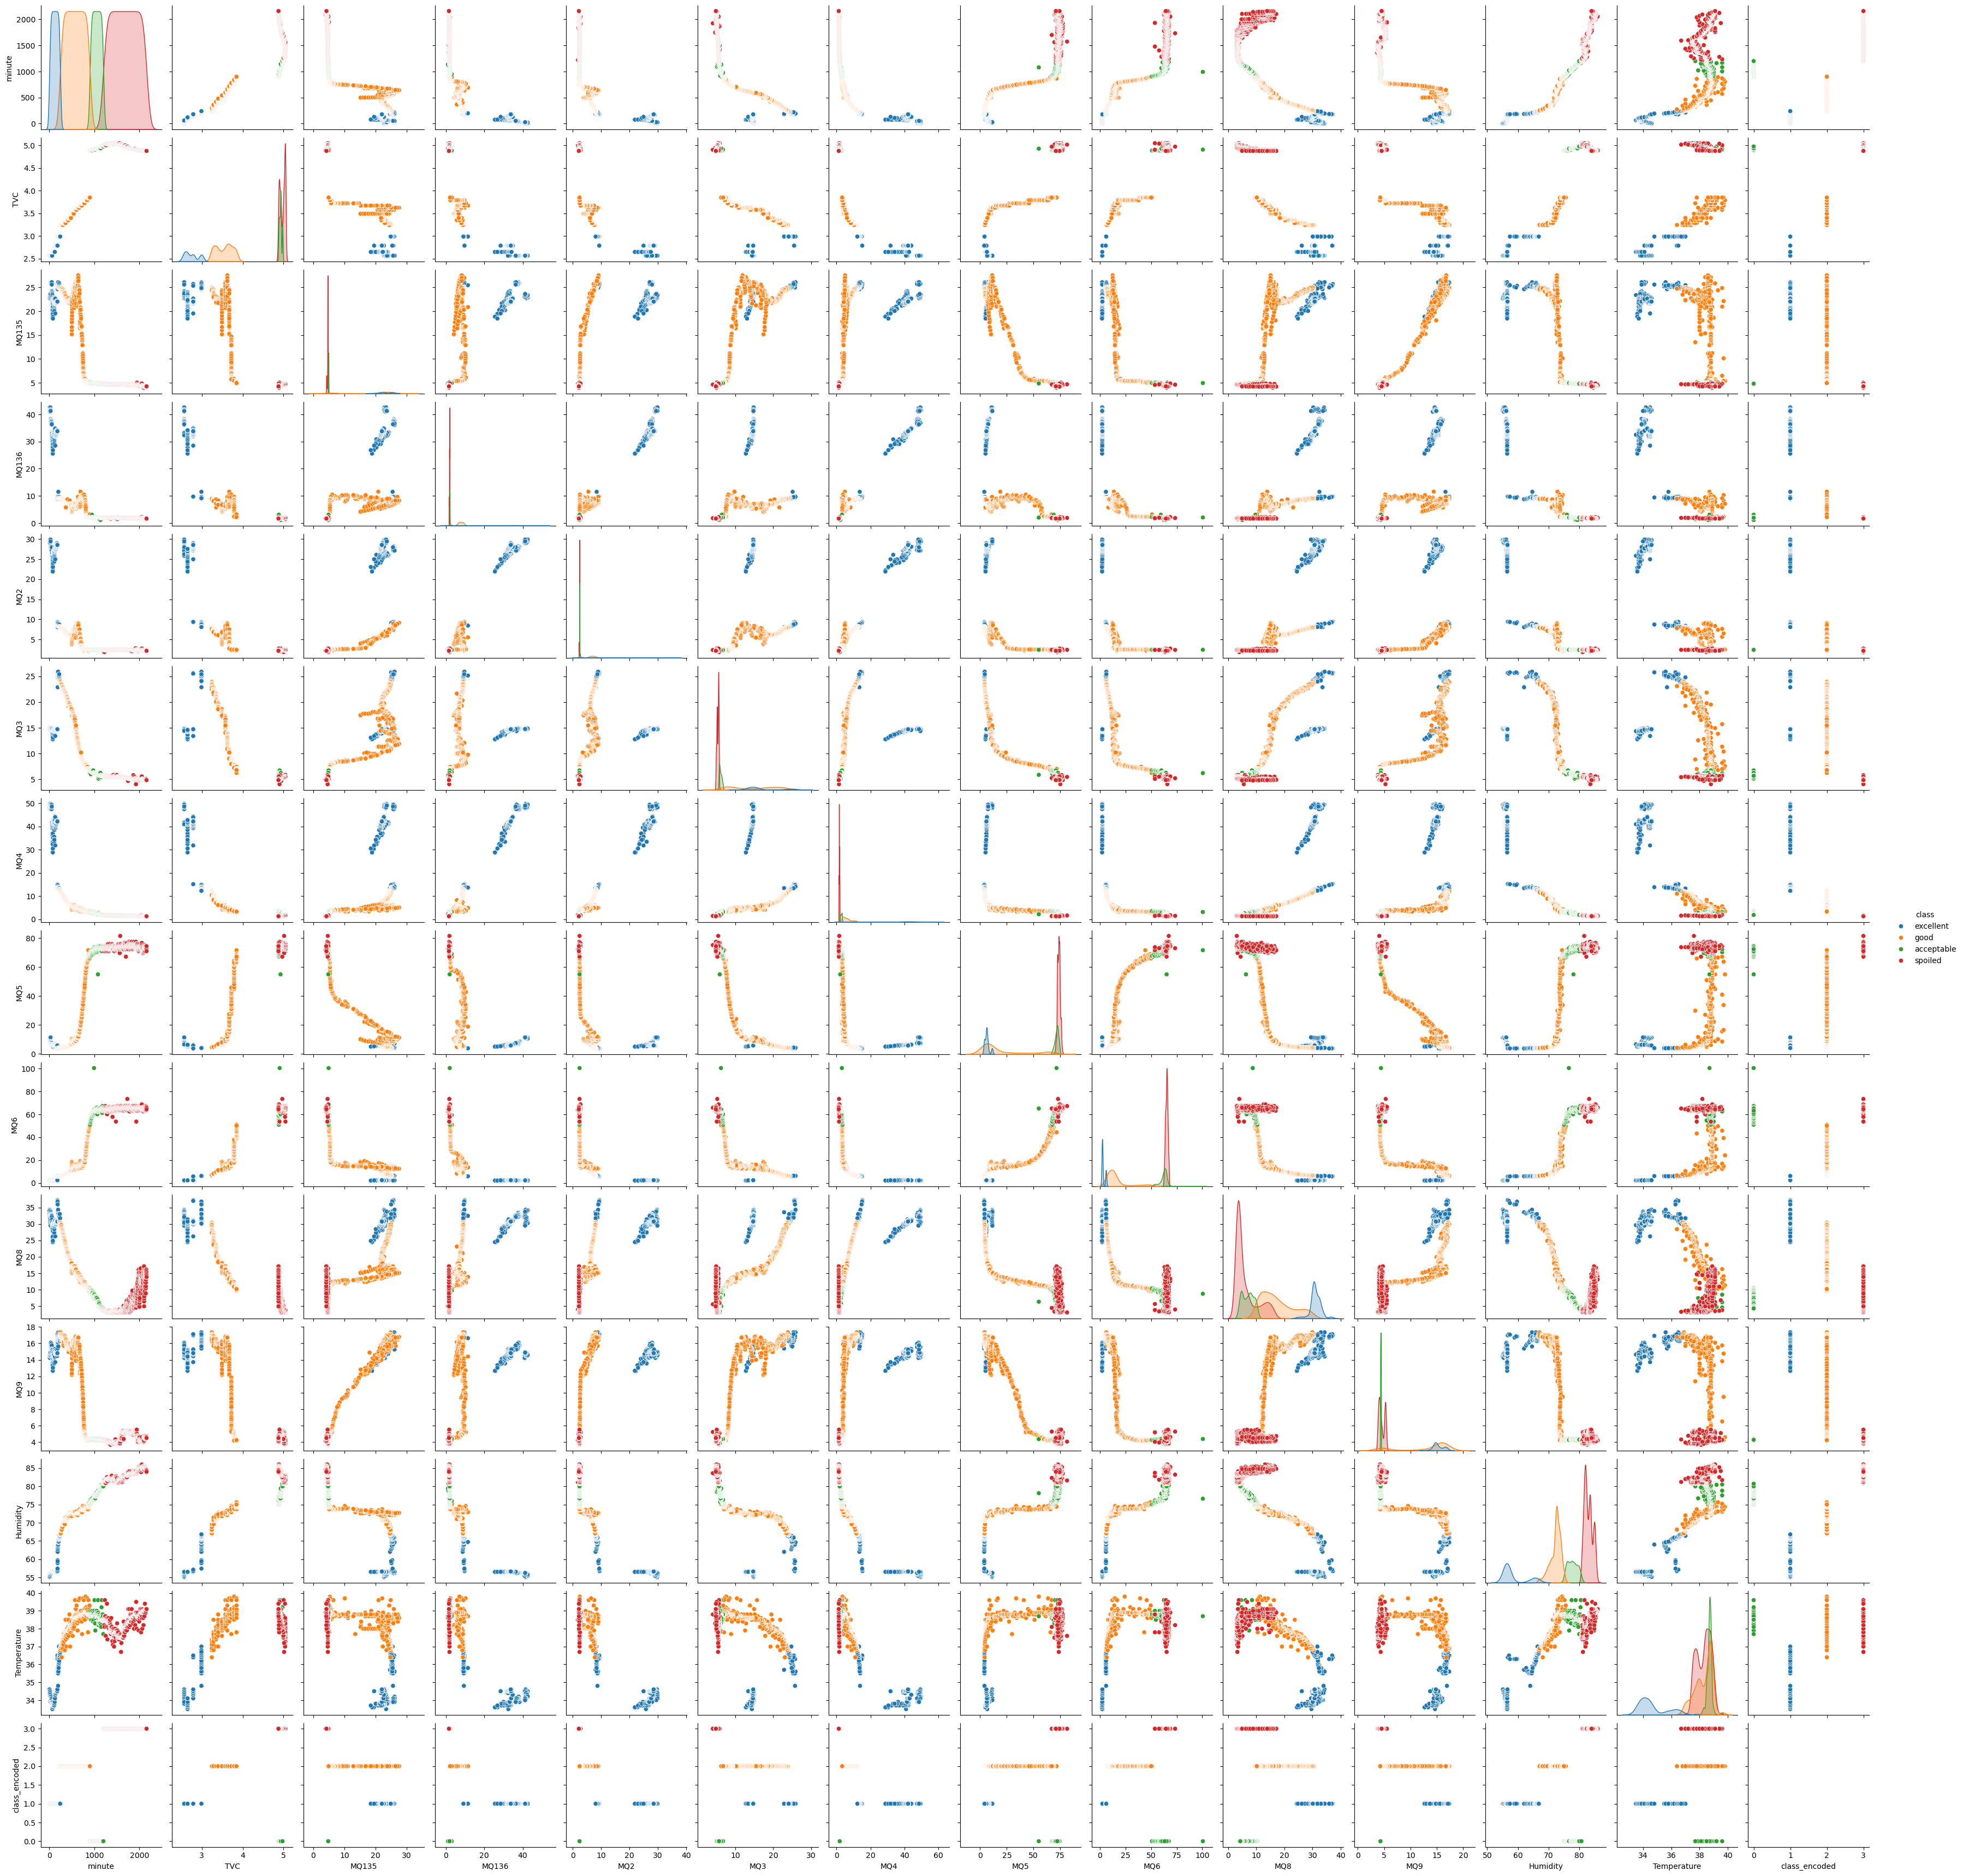

In [61]:
# Distribubtion of features by class using pairplot
sns.pairplot(df, hue='class')

Feature Engineering

In [62]:
# Separate X - y
X = df.drop(columns=['minute', 'class', 'class_encoded', 'TVC'])
y = df['class_encoded']

In [63]:
# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Train - Test Split

In [64]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Model Training (Multiclass Classification)

In [65]:
# Baseline: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [66]:
# Prediction and evaluation 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9953703703703703
              precision    recall  f1-score   support

  acceptable       1.00      0.97      0.98        60
   excellent       1.00      1.00      1.00        48
        good       0.99      1.00      1.00       132
     spoiled       0.99      1.00      1.00       192

    accuracy                           1.00       432
   macro avg       1.00      0.99      0.99       432
weighted avg       1.00      1.00      1.00       432



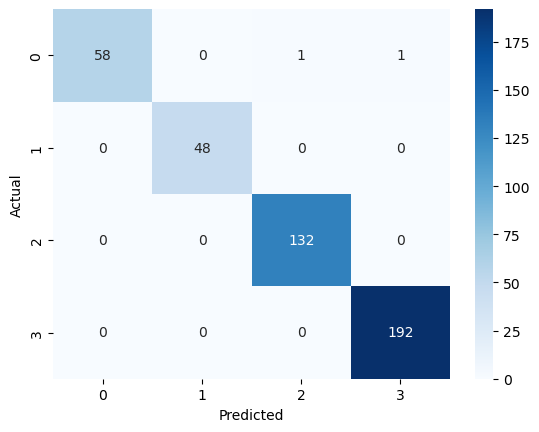

In [67]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Feature Importance

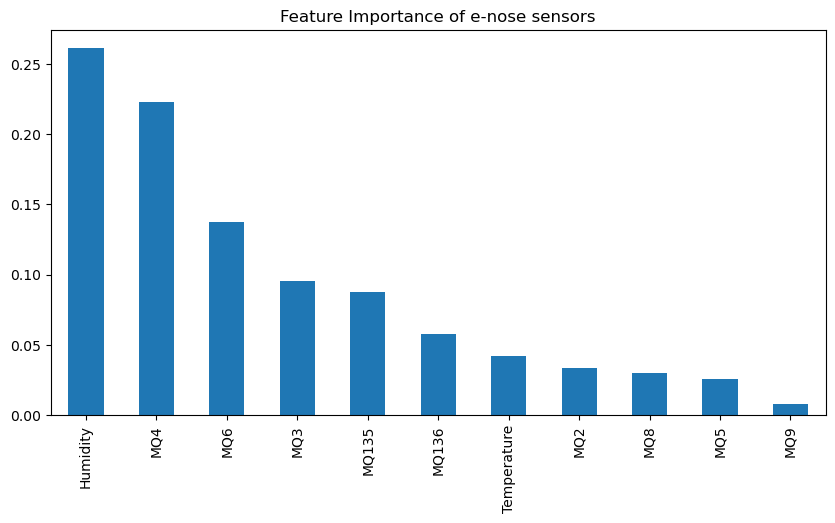

In [69]:
# Feature importance 
importances = rf.feature_importances_
features = df.drop(columns=['minute', 'class', 'class_encoded', 'TVC']).columns

fi = pd.Series(importances, index=features).sort_values(ascending=False)
fi.plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance of e-nose sensors")
plt.show()

Regression – Microbial Prediction

In [ ]:
# Regression – Microbial Prediction 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

y_microbes = df['TVC'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_microbes, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train, y_train)

y_pred_reg = rf_reg.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred_reg))
print("R^2 Score:", r2_score(y_test, y_pred_reg))
print(f"  ✓ Model explains {r2_score(y_test, y_pred_reg)*100:.2f}% of TVC variance")
print(f"  ✓ Average prediction error: ±{mean_squared_error(y_test, y_pred_reg, squared=False):.4f} log CFU/g")

Mean Squared Error: 6.31584963527604e-05
R^2 Score: 0.9999284053195171
  ✓ Model explains 99.99% of TVC variance
  ✓ Average prediction error: ±0.0079 log CFU/g


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Model Training (Multiclass Classification) - Giải thích chi tiết

### Đoạn 1: Khởi tạo và train Random Forest
```python
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
```

**Mục đích:**
- **Random Forest**: Mô hình dựa trên quyết định (decision trees) - rất tốt cho dữ liệu sensor
- **n_estimators=200**: Tạo 200 cây quyết định → mỗi cây vote → chọn class có phiếu nhiều nhất
- **random_state=42**: Đảm bảo kết quả reproducible (giống nhau mỗi lần chạy)

**Tại sao Random Forest tốt cho e-nose?**
- ✅ Không bị sensor có range lớn áp đảo (không cần chuẩn hóa nhưng ở đây vẫn chuẩn hóa)
- ✅ Xử lý multicollinearity tốt (các sensor tương quan cao)
- ✅ Xác định feature importance (sensor nào quan trọng nhất)
- ✅ Ít overfitting (ensemble method)

**Công thức quyết định:**
```
Class = argmax(votes từ 200 cây)
```

---

### Đoạn 2: Dự đoán và Đánh giá (Prediction & Evaluation)
```python
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
```

**Mục đích:**
- **y_pred**: Dự đoán class cho test set
- **accuracy_score**: Tỷ lệ dự đoán đúng = TP+TN / Total
- **classification_report**: Chi tiết cho từng class

**Output gồm:**

| Metric | Ý nghĩa | Công thức |
|---|---|---|
| **Precision** | Trong những sample dự đoán là class X, bao nhiêu % đúng? | TP / (TP + FP) |
| **Recall (Sensitivity)** | Trong những sample thực tế là class X, model bắt được bao nhiêu %? | TP / (TP + FN) |
| **F1-score** | Balance giữa precision và recall | 2 × (P×R)/(P+R) |
| **Support** | Số sample của class trong test set | Đơn vị |

**Ví dụ:**
```
              precision    recall  f1-score   support
         bad       0.95      0.92      0.93       120
        good       0.88      0.90      0.89       110
    excellent      0.92      0.95      0.93       100
    
    accuracy                           0.92       330
```

Nghĩa là:
- Class "bad": Model đoán đúng 95% những gì nó gọi là "bad", bắt được 92% những sample "bad" thực tế
- Accuracy chung: 92% dự đoán đúng

---

### Đoạn 3: Confusion Matrix (Ma trận nhầm lẫn)
```python
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
```

**Confusion Matrix là gì?**

```
                 Predicted Bad  Predicted Good  Predicted Excellent
Actual Bad              110            8                2
Actual Good              5            99                6
Actual Excellent         1            4                95
```

**Đọc cách:**
- **Đường chéo chính** (110, 99, 95): Dự đoán đúng ✅
- **Off-diagonal**: Dự đoán sai ❌
- Nếu off-diagonal lớn → model nhầm class (ví dụ: "good" dự đoán thành "bad")

**Ví dụ nhận xét:**
- 8 sample "bad" nhầm thành "good" → sensor có overlap → khó phân biệt
- 2 sample "bad" nhầm thành "excellent" → lỗi lớn → cần cẩn thận

---

## Tóm tắt 3 bước:
1️⃣ **Train RF**: Mô hình học từ X_train - y_train (80% data)
2️⃣ **Predict + Evaluate**: Test trên X_test (20% data) → xem precision/recall/F1
3️⃣ **Confusion Matrix**: Trực quan hóa lỗi phân loại → phát hiện class nào khó phân biệt


## 2 bước sau Feature Engineering: Tách X-y + Chuẩn hóa

### Bước 1: Tách X (Features) và y (Target)
```python
X = df.drop(columns=['minute', 'class', 'class_encoded'])
y = df['class_encoded']
```

**Mục đích:**
- **X**: Tất cả sensor readings (MQ135, MQ136,...) → dùng để dự đoán
- **y**: Class được encode (0, 1, 2,...) → cái chúng ta muốn dự đoán
- Lý do tách: Model chỉ học từ X → dự đoán y

**Tại sao loại bỏ:**
- `minute`: Chỉ là chỉ số thời gian, không phải đặc trưng cảm biến
- `class`: Dạng text, không thể dùng cho ML
- `class_encoded`: Thừa (y đã có rồi)

---

### Bước 2: Chuẩn hóa (Standardization)
```python
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
```

**Mục đích: Đưa tất cả feature về cùng scale (mean=0, std=1)**

**Tại sao cần bắt buộc với sensor?**

| Mà không chuẩn hóa | Với chuẩn hóa |
|---|---|
| MQ135: 0-1000 | MQ135: -2.3 đến +1.5 |
| MQ136: 0-100 | MQ136: -2.1 đến +1.8 |
| MQ137: 0-500 | MQ137: -2.4 đến +1.6 |
| Sensor có range lớn → **áp đảo** sensor có range nhỏ | Tất cả balanced → Model learn từ tất cả equally |

**Ví dụ:**
- Nếu MQ135 (0-1000) không chuẩn hóa → Model sẽ **coi trọng MQ135 hơn** (vì số lớn)
- Chuẩn hóa → Model coi tất cả sensor **ngang nhau**

**Công thức Standardization:**
$$X_{scaled} = \frac{X - mean(X)}{std(X)}$$

→ **Bắt buộc với SVM, KNN, Neural Networks** (nhạy cảm với scale)
→ **Không bắt buộc với Random Forest** (không phụ thuộc scale)


## Hàm `sns.pairplot()` là gì?

### Định nghĩa
```
sns.pairplot(df, hue='class')
```
Vẽ **tất cả các cặp biến** (feature pairs) trên cùng một hình:
- **Đường chéo**: Histogram của mỗi feature (phân phối đơn biến)
- **Off-diagonal**: Scatter plot 2D của các cặp feature (mối quan hệ giữa 2 feature)
- **hue='class'**: Tô màu theo class → dễ so sánh giữa các class

### Tại sao tách biệt → Accuracy cao?

**Nguyên tắc cơ bản của Machine Learning:**
- **Model học để tìm decision boundary** → một "ranh giới" để phân chia các class
- **Nếu các class tách biệt rõ ràng** → decision boundary dễ tìm → mô hình học nhanh, chính xác
- **Nếu các class lẫn lộn** → decision boundary phức tạp → mô hình khó học

### 5 Lý do tách biệt → Accuracy cao:

| Tách biệt trực quan | Lý do → Accuracy cao |
|---|---|
| **1. Decision boundary đơn giản** | Các class nằm riêng biệt → dùng đường thẳng/đơn giản có thể phân chia |
| **2. Overfitting ít hơn** | Không cần mô hình phức tạp → bias-variance trade-off tốt |
| **3. Feature có khả năng phân biệt cao** | Sensor nào tách biệt tốt → feature đó chứa thông tin quan trọng |
| **4. Không cần xử lý dữ liệu phức tạp** | Không cần PCA, feature selection → train nhanh, độ chính xác cao |
| **5. Dễ generalize** | Model không phụ thuộc vào chi tiết nhỏ → hoạt động tốt trên data mới |

### Ví dụ cụ thể:

**Trường hợp A - Tách biệt tốt:**
```
Feature 1: good (50-100), bad (10-40), excellent (80-150)
→ Có overlap nhưng tách biệt rõ
→ Accuracy: 85-95%
```

**Trường hợp B - Lẫn lộn:**
```
Feature 1: good (50-100), bad (50-100), excellent (50-100)
→ Lẫn hoàn toàn
→ Accuracy: ~33% (random guess vì 3 class)
```

### Cách đọc Pairplot:
- ✅ **Tốt**: Các màu tách biệt từng phía (trái/phải hoặc trên/dưới)
- ❌ **Xấu**: Các màu xen kẽ nhau hỗn loạn


## Nhưng các sensor đo khí khác nhau - tại sao vẫn tách biệt?

### Bối cảnh:
- **MQ135**: đo CO₂, NH₃, NOₓ, khí cồn,...
- **MQ136**: đo H₂S, CO,...
- **MQ137**: đo NH₃,...
- v.v.

### Tại sao các sensor khác nhau lại cùng **tách biệt** các class?

**Nguyên nhân:**

1. **Cùng phản ứng với nguyên nhân gốc** ← đây là điểm then chốt!
   - Các sensor khác nhau nhưng đều **phản ứng với thành phần chất lượng thực phẩm**
   - Ví dụ: Thực phẩm "bad" → tạo ra NH₃, H₂S, CO₂ (vi khuẩn phân huỷ)
   - Cả MQ135, MQ136, MQ137 đều **nhạy cảm với những chất này**
   - → Tất cả đều tăng cùng lúc khi thực phẩm xấu → cùng tách biệt các class

   ```
   Chất lượng thực phẩm (khó đo trực tiếp)
           ↓
   Sinh ra các khí: NH₃, H₂S, CO₂,...
           ↓
   MQ135, MQ136, MQ137 → tất cả tăng
           ↓
   Chúng cùng tách biệt class "good" vs "bad"
   ```

2. **Overlapping Selectivity** (như notebook đã nói)
   - Mặc dù "chuyên biệt" nhưng các sensor có **vùng đáp ứng chồng lên nhau**
   - Không phải tính tương quan là do dư thừa → mà do **chúng cùng phản ứng với tín hiệu chung**

### So sánh 2 trường hợp:

| Trường hợp | Giải thích |
|---|---|
| **Sensor độc lập** (đo các khí hoàn toàn khác nhau) | MQ135 (CO₂), MQ136 (H₂S) - nếu không có liên hệ gì → ít tương quan |
| **Sensor của bạn** (MQ135, MQ136,...) | Tất cả đều phản ứng với sự phân huỷ → tương quan cao + tách biệt tốt |

### Kết luận:
✅ **Các sensor khác nhau nhưng vẫn tách biệt tốt** vì chúng **cùng đo một "nguyên nhân ẩn"** (hidden signal) = **chất lượng/tính tươi mới của thực phẩm**

→ Đây là **điều tốt** cho ML: nhiều sensor phản ứng với cùng 1 tín hiệu = **redundancy cao** → chắc chắn học được pattern


🔷 DATA SCIENCE PIPELINE CHO DATASET E-NOSE
0️⃣ Import & load data
1️⃣ Data Understanding
1.1 Kiểm tra cấu trúc
1.2 Kiểm tra class
2️⃣ Data Cleaning
2.1 Missing values
2.2 Outlier (rất hay gặp với sensor)
3️⃣ Label Encoding
4️⃣ Exploratory Data Analysis (EDA)
4.1 Correlation giữa sensor
4.2 Phân phối dữ liệu theo class
5️⃣ Feature Engineering
5.1 Tách X – y
5.2 Chuẩn hóa (bắt buộc với sensor)
6️⃣ Train – Test Split
7️⃣ Model Training (Multiclass Classification)
7.1 Baseline: Random Forest
7.2 Prediction & Evaluation
7.3 Confusion Matrix
8️⃣ Feature Importance
👉 Nhận xét:
Sensor nào quan trọng nhất?
Có thể loại bớt sensor không?
9️⃣ (MỞ RỘNG) PCA – xử lý overlapping selectivity
- Train lại model với PCA → so sánh accuracy
🔟 (OPTIONAL) Regression – Microbial Prediction



| Mục tiêu             | Đồ thị       |
| -------------------- | ------------ |
| Drift theo thời gian | Line plot    |
| So sánh sensor       | Multi-line   |
| Phân biệt class      | Boxplot      |
| Pattern tổng thể     | Heatmap      |
| Noise handling       | Rolling mean |
| Overlap              | Correlation  |
| Trực quan hóa ML     | PCA scatter  |


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df['MQ135', 'MQ136']
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=df['class'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of e-nose sensor data")
plt.show()


KeyError: ('MQ135', 'MQ136')

Drift:

| Noise               | Drift         |
| ------------------- | ------------- |
| Ngẫu nhiên          | Có xu hướng   |
| Ngắn hạn            | Dài hạn       |
| Dao động quanh mean | Mean thay đổi |
| Có thể lọc          | Khó xử lý     |

4️⃣ Drift nguy hiểm thế nào trong ML?
❌ Nếu không xử lý:

Model học thời gian, không học mùi

Accuracy cao giả

Model fail khi gặp data mới

Ví dụ:

Train bằng TS1

Test bằng TS5 → accuracy tụt mạnh

➡️ Đây gọi là batch effect.